In [1]:
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.signals.common import Waveform





from sigvisa.source.event import get_event

from sigvisa.infer.run_mcmc import run_open_world_MH

from sigvisa.infer.mcmc_logger import MCMCLogger

# Sampling observed signals and arrival times

In [7]:

from sigvisa.synthetic.doublets import *

def sample_events(basedir, seed=0):
    n_evs = 10
    lons = [129, 130]
    lats = [-3.5, -4.5]
    times = [1238889600, 1245456000]
    mbs = [4.0, 5.0]
    
    rtime = lambda : np.random.rand()*(times[1]-times[0])+times[0]
    evs = [Event(lon=129.0, lat=-4.0, depth=0.0, mb=4.5, time=rtime()), 
           Event(lon=129.1, lat=-4.0, depth=0.0, mb=4.5, time=rtime()), 
           Event(lon=129.2, lat=-4.0, depth=0.0, mb=4.5, time=rtime()), 
           Event(lon=129.3, lat=-4.0, depth=0.0, mb=4.5, time=rtime()), ]
    
    sw = SampledWorld(seed=seed)
    sw.add_events(evs)
    sw.stas = ["MK31", "AS12", "CM16", "FITZ", "WR1"]
    gpcov = GPCov([0.7,], [ 80.0, 5.0],
                  dfn_str="lld",
                  wfn_str="compact2")
    param_means = build_param_means(sw.stas)
    sw.set_basis(wavelet_family="db4_2.0_3_30", iid_repeatable_var=0.1,
                  iid_nonrepeatable_var=0.4, srate=5.0)
    sw.joint_sample_arrival_params(gpcov, param_means)
    sw.sample_signals("freq_0.8_4.5")

    wave_dir = os.path.join(basedir, "sampled_%d_line" % seed)
    sw.serialize(wave_dir)
    #sw.train_gp_models_true_data()
    #sw.save_gps(wave_dir, run_name="synth_truedata")
    return sw

import os
basedir = os.path.join(os.getenv("SIGVISA_HOME"), "experiments", "synth_wavematch")
#sw = sample_events(basedir)

wave_dir = os.path.join(basedir, "sampled_%d_line" % 0)
sw = load_sampled_world(wave_dir)


ERROR: No traceback has been produced, nothing to debug.


# Build sg for inference

In [65]:
import copy

def set_true_templates(sg, sw):
    for sta in sw.tm_params.keys():
        for i in range(len(sw.evs)):
            tmnodes = sg.get_template_nodes(eid=i+1, sta=sta, phase=sw.phase, chan=sw.chans[sta], band=sw.band)
            for param in sw.tm_params[sta]:
                k, n = tmnodes[param]
                n.set_value(sw.tm_params[sta][param][i])



def build_sg(sw, wiggle_family="db4_2.0_3_30", wiggle_model_type="gp_joint"):
    dummyPrior = dict([(param, Gaussian(sw.param_means["MK31"][param], std=np.sqrt(sw.gpcov.wfn_params[0]))) for param in sw.param_means["MK31"].keys()
])
    sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",
                      wiggle_model_type=wiggle_model_type, wiggle_family=wiggle_family,
                      phases=["P",], nm_type = "ar", runids=(-1,), joint_wiggle_prior=(0.01, sw.gpcov), 
                      dummy_prior=dummyPrior)

    for i in sw.waves.keys():
        for sta in sw.waves[i].keys():
            wn = sg.add_wave(sw.waves[i][sta])
            basis, iid_std, target_coef = wn.wavelet_basis
            wn.wavelet_basis = (basis, sw.scaled, target_coef)

    for ev in sw.all_evs:
        sg.add_event(ev)

    set_true_templates(sg, sw)
    return sg

# Simple custom inference from ttimes

In [31]:
from sigvisa import Sigvisa
from sigvisa.utils.geog import dist_km
from sigvisa.models.ttime import tt_predict
s = Sigvisa()

sta_locs = dict()
for sta in sw.stas:
    sta_locs[sta] = s.earthmodel.site_info(sta, 0)[:2]
print sta_locs

initX = np.array([(ev.lon, ev.lat, ev.time) for ev in sw.evs])
initx = initX.flatten()

obs_atimes = dict()
for sta in sw.tm_params.keys():
    obs_atimes[sta] = []
    for i, ev in enumerate(sw.evs):
        r = sw.tm_params[sta]['tt_residual'][i]
        obs_atimes[sta].append(ev.time+tt_predict(ev, sta, 'P')+r)

print obs_atimes

{'MK31': (82.2904, 46.7937), 'FITZ': (125.6403, -18.09826), 'WR1': (134.33951, -19.942589), 'AS12': (133.90573, -23.664895), 'CM16': (98.942992, 18.457454)}
{'MK31': [1244979597.7816525, 1241356939.4621265, 1241082248.7513242, 1242899787.7934725], 'FITZ': [1244979158.3503685, 1241356502.0601387, 1241081810.5011609, 1242899349.075604], 'WR1': [1244979188.7285509, 1241356530.8789706, 1241081838.4436936, 1242899378.6001785], 'CM16': [1244979385.2172532, 1241356729.2301736, 1241082039.7639849, 1242899579.6229267], 'AS12': [1244979229.4592996, 1241356571.0861609, 1241081878.9475462, 1242899416.9620667]}


In [44]:
def tt_ll(x):
    ll = 0
    X = x.reshape((-1, 3))
    for i, xx in enumerate(X):
        ev = Event(lon=xx[0], lat=xx[1], depth=0, time=xx[2], mb=4.5)
        for sta in sw.stas:
            pred_atime = ev.time+tt_predict(ev, sta, 'P')
            r = obs_atimes[sta][i] - pred_atime
            dll = dummyPrior['tt_residual'].log_p(r)
            ll += dll            
    return ll

def mh_step(X, i, lp_old, f_ll, stds):
    Xnew = X.copy()
    Xnew[i,:] += np.random.randn(X.shape[1])*stds
    lp_new = f_ll(Xnew)
    
    log_u = np.log(np.random.rand())
    if lp_new - lp_old > log_u:
        return Xnew, lp_new, True
    else:
        return X, lp_old, False
    
def run_mcmc(Xinit, steps=200, f_ll=tt_ll, stds=None):
    
    if stds is None:
        stds = np.array((0.05, 0.05, 0.5))
    
    n = Xinit.shape[0]
    X = Xinit.copy()
    lp = f_ll(X)
    accepteds = []
    Xs = []
    lps = []
    for step in range(steps):
        for i in range(n):
            X, lp, accepted = mh_step(X, i, lp, f_ll=f_ll, stds=stds)
            accepteds.append(accepted)
        Xs.append(X)
        lps.append(lp)
        if step % 10 == 9:
            print "step", step, "lp", lp, "acceptance rate", np.mean(accepteds)
            
    return Xs, lps



In [45]:
Xs, lps = run_mcmc(initX, steps=500)

step 9 lp -27.4756336966 acceptance rate 0.4
step 19 lp -24.6628608594 acceptance rate 0.4125
step 29 lp -29.6549354794 acceptance rate 0.375
step 39 lp -22.5621634524 acceptance rate 0.3875
step 49 lp -26.113421998 acceptance rate 0.415
step 59 lp -27.2647009229 acceptance rate 0.425
step 69 lp -23.0240521012 acceptance rate 0.453571428571
step 79 lp -26.679503561 acceptance rate 0.46875
step 89 lp -24.2456624255 acceptance rate 0.466666666667
step 99 lp -22.7153775223 acceptance rate 0.455
step 109 lp -22.9098700962 acceptance rate 0.454545454545
step 119 lp -27.7832711483 acceptance rate 0.46875
step 129 lp -23.3571583597 acceptance rate 0.467307692308
step 139 lp -25.1071702697 acceptance rate 0.4625
step 149 lp -27.4095882229 acceptance rate 0.463333333333
step 159 lp -27.954518619 acceptance rate 0.465625
step 169 lp -25.335200321 acceptance rate 0.470588235294
step 179 lp -25.6049682738 acceptance rate 0.470833333333
step 189 lp -25.0852920309 acceptance rate 0.476315789474
step

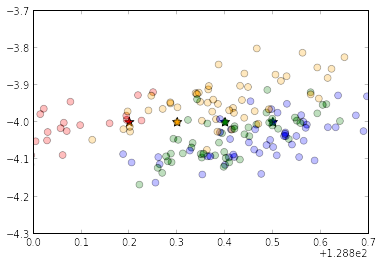

In [57]:
def visX(X, ax=None, **kwargs):
    colors = ('red', 'orange', 'green', 'blue', 'purple')
    ax = gca() if ax is None else ax
    for i in range(X.shape[0]):
        ax.scatter(X[i, 0], X[i, 1], c=colors[i], **kwargs)
    ax.set_xlim([128.8, 129.5])

def visMCMC(Xs, initX):
    ax = gca()
    visX(initX, ax=ax, alpha=1.0, s=100, marker="*")
    for X in Xs[::10]:
        visX(X, ax=ax, alpha=0.5, s=50)
    
visMCMC(Xs, initX)

# Posteriors from difference observations

In [50]:
from sigvisa import Sigvisa
from sigvisa.utils.geog import dist_km
from sigvisa.models.ttime import tt_predict


initX = np.array([(ev.lon, ev.lat, ev.time) for ev in sw.evs])

diff_dist = Gaussian(mean=0, std=0.1)
differences = dict()
for sta in sw.tm_params.keys():
    differences[sta] = dict()
    for i, ev1 in enumerate(sw.evs):
        pred1 = tt_predict(ev1, sta, 'P')
        for j, ev2 in enumerate(sw.evs):
            if j <= i: continue
            pred2 = tt_predict(ev2, sta, 'P')
            true_diff = pred2-pred1
            obs_diff = true_diff + diff_dist.sample()
            differences[sta][(i,j)] = obs_diff

In [55]:
def diff_ll(x):
    ll = 0
    X = x.reshape((-1, 3))
    for i, xx1 in enumerate(X):
        ev1 = Event(lon=xx1[0], lat=xx1[1], depth=0, time=xx1[2], mb=4.5)
        for j, xx2 in enumerate(X[:,:]):
            if j <= i: continue
            ev2 = Event(lon=xx2[0], lat=xx2[1], depth=0, time=xx2[2], mb=4.5)
            for sta in sw.stas:
                pred1 = ev.time+tt_predict(ev1, sta, 'P')
                pred2 = ev.time+tt_predict(ev2, sta, 'P')
                pred_diff = pred2-pred1
                r = differences[sta][(i,j)] - pred_diff
                dll = diff_dist.log_p(r)
                ll += dll
    return ll

def full_ll(x):
    return diff_ll(x) + tt_ll(x)



In [56]:
diff_stds = np.array((0.01, 0.01, 0.1))
Xs_diff, lps = run_mcmc(initX, steps=500, f_ll=diff_ll, stds=diff_stds)
Xs_full, lps = run_mcmc(initX, steps=500, f_ll=full_ll, stds=diff_stds)


step 9 lp 30.9720948821 acceptance rate 0.225
step 19 lp 29.1466142324 acceptance rate 0.225
step 29 lp 32.6043558071 acceptance rate 0.233333333333
step 39 lp 30.2648616741 acceptance rate 0.24375
step 49 lp 31.9506897559 acceptance rate 0.23
step 59 lp 32.9538971849 acceptance rate 0.216666666667
step 69 lp 30.957727788 acceptance rate 0.207142857143
step 79 lp 32.920843565 acceptance rate 0.203125
step 89 lp 31.8207731264 acceptance rate 0.205555555556
step 99 lp 30.0583561646 acceptance rate 0.2225
step 109 lp 31.7177683045 acceptance rate 0.215909090909
step 119 lp 29.2097807785 acceptance rate 0.2125
step 129 lp 32.2527696783 acceptance rate 0.213461538462
step 139 lp 30.0561424251 acceptance rate 0.217857142857
step 149 lp 33.9684936753 acceptance rate 0.213333333333
step 159 lp 29.5730024834 acceptance rate 0.2171875
step 169 lp 31.2555599628 acceptance rate 0.223529411765
step 179 lp 32.0219047498 acceptance rate 0.223611111111
step 189 lp 29.9770709071 acceptance rate 0.23157

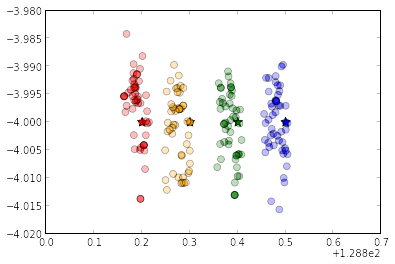

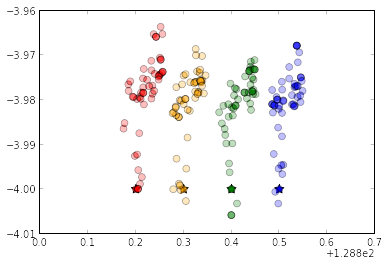

In [58]:
visMCMC(Xs_diff, initX)
figure()
visMCMC(Xs_full, initX)

# Sigvisa: nonrepeatable wiggles

In [61]:
sg = build_sg(sw, wiggle_model_type="dummy", wiggle_family="dummy")

TypeError: 'NoneType' object is not iterable

# Sigvisa: repeatable wiggles

In [ ]:
# TODO: fix the above for nonrepeatable models
# try with one sta and all five stas

In [66]:
sg = build_sg(sw)

In [ ]:
logger = MCMCLogger(write_template_vals=False, dump_interval=5)

with open(os.path.join(logger.run_dir, "events.pkl"), "wb") as f:
    pickle.dump(sw.evs, f)
    
run_open_world_MH(sg, steps=1000,
                  enable_template_moves=True,
                  enable_event_moves=True,
                  logger=logger,
                  enable_event_openworld=False,
                  enable_template_openworld=False)